In [1]:
from fnet import FeedForwardNet
import numpy as np
import torch
import crocoddyl
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def random_positions(size:int = 3000,
                         xlim = [-2.1,2.1],
                         ylim = [-2.1,2.1],
                         zlim = [-np.pi/2,np.pi/2],
                         as_tensor:bool = False):
    """
    Generate randomly sampled x, y, z from the ranges given.
    @params:
        1: size      = size of the array to generate
        2: xlim      = range of x positions
        3: ylim      = range of y positions
        4: zlim      = range of z positions
        5: as_tensor = bool, True if data is needed in the form of tensors
        
    @returns:
        1: dataset = [x, y, theta], where x, y, theta have been generated randomly
    
    """

    x = np.random.uniform(*xlim, size = (size, 1))
    y = np.random.uniform(*ylim, size = (size, 1))
    z = np.random.uniform(*zlim, size = (size, 1))
    
    dataset = np.hstack((x, y, z))
    
    if as_tensor:
        dataset = torch.tensor(dataset, dtype = torch.float32)
        return dataset
    
    else: return dataset
    
    
    
    
def grid_data(size:int = 10,
             xy_limits = [-2., 2.],
             theta_lims = [-np.pi/2, np.pi/2],
             as_tensor:bool = False
             ):
    """
    @params:
        1: size   = number of grid points
        2: limits = xlim, ylim
    
    @returns:
        1: grid array        
    """
    min_x, max_x = xy_limits
    xrange = np.linspace(min_x,max_x,size)
    dataset = np.array([ [x1,x2, np.random.uniform(*theta_lims)] for x1 in xrange for x2 in xrange ])
    
    if as_tensor:
        dataset = torch.tensor(dataset, dtype = torch.float32)
        return dataset
    
    else: return dataset

In [3]:
def train_data(dataset):
    
    x_data, y_data = [], []
    
    for data in dataset:
        model = crocoddyl.ActionModelUnicycle()
        model.costWeights = np.array([1., 1.]).T
        
        problem = crocoddyl.ShootingProblem(data, [model] * 30, model)
        
        ddp = crocoddyl.SolverDDP(problem)
        
        ddp.solve([], [], 1000)
        
        values = []
        for d in ddp.problem.runningDatas:
            values.append(d.cost)
            
        for i in range(len(values)):
            values[i] =  sum(values[i:]) + ddp.problem.terminalData.cost
        values.append(ddp.problem.terminalData.cost)    
        
        xs = np.array(ddp.xs)
       
        for node, cost in zip(xs, values):
            x_data.append(node)
            y_data.append(cost)
        del values, xs    
        
    return np.array(x_data), np.array(y_data).reshape(-1,1)
        

In [4]:
# Generate Random starting positions
r_p = random_positions(1000)

In [5]:
# Get training data

s, v = train_data(r_p)
xtrain, ytrain = torch.tensor(s, dtype = torch.float32), torch.tensor(v, dtype = torch.float32)

In [6]:
net = FeedForwardNet(fc1_dims=20, fc2_dims=20)

In [7]:
# Dataloader
dataset = torch.utils.data.TensorDataset(xtrain, ytrain)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 1000)

criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3, weight_decay=0.1)  


net.train()
    

FeedForwardNet(
  (activation): Tanh()
  (fc1): Linear(in_features=3, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)

In [8]:
for epoch in tqdm(range(10000)):        
        for data, target in dataloader: 

            output = net(data)
            loss = criterion(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


100%|██████████| 10000/10000 [43:36<00:00,  3.82it/s] 


In [10]:
from terminal_unicycle import FeedforwardUnicycle


In [94]:
model = crocoddyl.ActionModelUnicycle()
model.costWeights = np.array([1,1.]).T
x0 = np.array([-1.99, 0.99, 0.654])
T  = 30
problem = crocoddyl.ShootingProblem(x0, [ model ] * T, model)
ddp = crocoddyl.SolverDDP(problem)
log = crocoddyl.CallbackLogger()
ddp.setCallbacks([log,
                  crocoddyl.CallbackVerbose()])
ddp.solve([], [], 1000)

c_log = log.stops[1:]

In [95]:
terminal_m = FeedforwardUnicycle(net)

model = crocoddyl.ActionModelUnicycle()
model.costWeights = np.array([1,1.]).T
T  = 30
problem = crocoddyl.ShootingProblem(x0.T, [ model ] * T, terminal_m)
ddp = crocoddyl.SolverDDP(problem)
log = crocoddyl.CallbackLogger()
ddp.setCallbacks([log,
                  crocoddyl.CallbackVerbose()])
ddp.th_stop = 1e-6
ddp.solve([], [], 1000)
p_log = log.stops[1:]
    


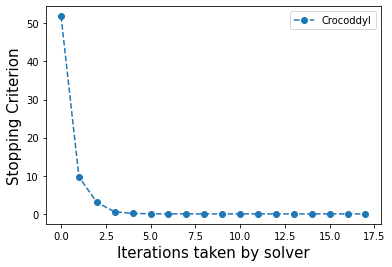

In [96]:
plt.clf()
plt.plot(c_log, "--o", label = "Crocoddyl")
#plt.plot(p_log, '--o', label = "Neural Net")
plt.ylabel("Stopping Criterion", fontsize = 15)
plt.xlabel("Iterations taken by solver", fontsize = 15)
#plt.xticks(np.arange(0, 32, step=4))
#plt.yticks(np.arange(0, 1., step=0.2))
plt.legend()
#plt.savefig("trainedNet.png")
plt.show()
